In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import kurtosis
from catboost import CatBoostRegressor, Pool, cv
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [2]:
# Read data
row_data=pd.read_excel('DataFl72_reup.xlsx', index_col=0)
row_data = row_data.reset_index(level=[0]).drop('#', axis=1)
row_data

,Ai1 min,ai1 mean,ai1 max,Ai2 min,ai2 mean,ai2 max,Ai3 min,ai3 mean,ai3 max,Mode
0,33.7,34.06,34.1,33.0,33.00,33.0,0.0,0.00,0.0,3
1,33.9,33.98,34.1,33.0,33.02,33.1,0.0,0.00,0.0,3
2,33.8,33.88,34.0,33.1,33.10,33.1,34.9,34.94,35.0,3
3,33.6,33.68,33.7,33.1,33.10,33.1,35.0,35.06,35.1,3
4,33.6,33.60,33.6,33.1,33.10,33.1,35.1,35.10,35.1,3
...,...,...,...,...,...,...,...,...,...,...
8066,35.0,35.40,35.5,32.7,32.70,32.7,33.5,33.50,33.5,2
8067,34.9,35.11,35.3,32.7,32.71,32.8,33.5,33.50,33.5,2
8068,35.0,35.18,35.4,32.7,32.75,32.8,33.5,33.50,33.5,2
8069,34.9,35.17,35.4,32.8,32.80,32.8,33.4,33.48,33.5,2


In [3]:
# Take a look at the data
print(row_data.describe())
print(row_data.info())

           Ai1 min     ai1 mean      ai1 max      Ai2 min     ai2 mean  \
count  8071.000000  8071.000000  8071.000000  8071.000000  8071.000000   
mean     29.407124    29.463779    29.516119    29.908599    29.922964   
std       3.724344     3.732760     3.758098     2.179576     2.157212   
min       0.000000    24.560000    24.600000     0.000000    26.300000   
25%      26.000000    26.000000    26.000000    27.900000    27.900000   
50%      27.700000    27.700000    27.800000    29.300000    29.300000   
75%      33.400000    33.445000    33.500000    32.100000    32.110000   
max      35.800000    35.820000    36.100000    33.900000    33.900000   

           ai2 max      Ai3 min     ai3 mean      ai3 max         Mode  
count  8071.000000  8071.000000  8071.000000  8071.000000  8071.000000  
mean     29.934977    34.772953    34.788967    34.800359     3.311857  
std       2.161137     1.109396     1.035357     1.031339     1.069578  
min      26.300000     0.000000     0.000

В данных присутствуют нулевые значения. Это выбросы, которые наблюдаются при включении оборудования. 

В данных есть склейка. Судя по всему, она находится в том месте, где некоторые датчики показывают ноль. 
Разделим датасет на два: до склейки (data1) и после (data2). 

Строки с нулевыми значениями в начале каждого куска удаляем: они не представляют интереса, так как такие значения наблюдаются только в момент включения (один из каналов инициализируется чуть раньше, чем другой, какое то время сигнал регистрируется на некоторых каналах некорректно). 

При работе системы либо мониторинг нужно запускать с задержкой, либо встроить в программу мониторинга функцию детекции отсутствия сигнала, чтобы не учитывать эти периоды.

Отсутствующих значений нет, типы данных соответствуют возможным значениям каждой фичи.


In [66]:
# Separate data
data1 = row_data.iloc[:1308].copy()
data2 = row_data.iloc[1308:].copy()

In [5]:
row_data

,Ai1 min,ai1 mean,ai1 max,Ai2 min,ai2 mean,ai2 max,Ai3 min,ai3 mean,ai3 max,Mode
0,33.7,34.06,34.1,33.0,33.00,33.0,0.0,0.00,0.0,3
1,33.9,33.98,34.1,33.0,33.02,33.1,0.0,0.00,0.0,3
2,33.8,33.88,34.0,33.1,33.10,33.1,34.9,34.94,35.0,3
3,33.6,33.68,33.7,33.1,33.10,33.1,35.0,35.06,35.1,3
4,33.6,33.60,33.6,33.1,33.10,33.1,35.1,35.10,35.1,3
...,...,...,...,...,...,...,...,...,...,...
8066,35.0,35.40,35.5,32.7,32.70,32.7,33.5,33.50,33.5,2
8067,34.9,35.11,35.3,32.7,32.71,32.8,33.5,33.50,33.5,2
8068,35.0,35.18,35.4,32.7,32.75,32.8,33.5,33.50,33.5,2
8069,34.9,35.17,35.4,32.8,32.80,32.8,33.4,33.48,33.5,2


In [6]:
# Drop zero rows
data1 = data1.drop(data1[(data1.min(axis=1) < 1)].index)
data2 = data2.drop(data2[(data2.min(axis=1) < 1)].index)

В качестве бейзлайна, попробуем использовать модель только на усренённых значениях сигнала. Они более устойчивы, есть предположение, что анализ минимального и минимального значений не даст значительного прироста точности модели.

Потом можно попробовать добавить в качестве фичей значения волатильности температуры (разность между максимальным и минимальным значениями в каждом периоде) по каждому из датчиков, и посмотреть, какой прирост точности это может обеспечить.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

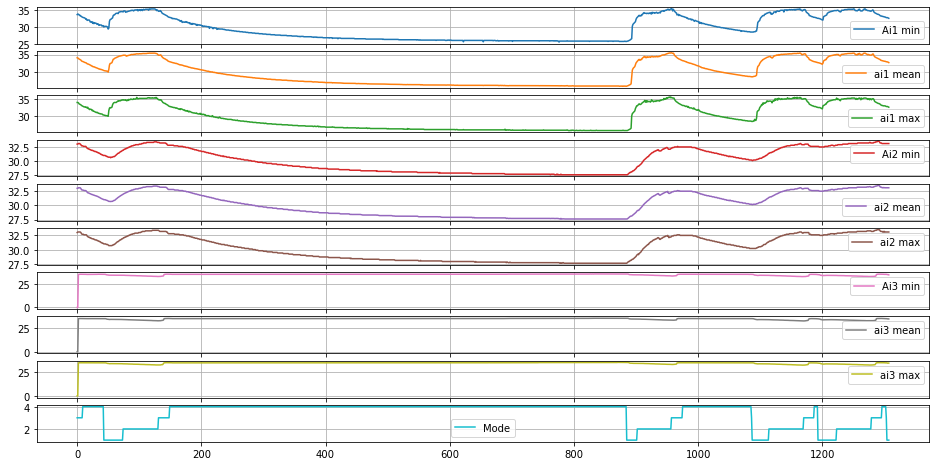

In [67]:
data1.plot(figsize=(16, 8), subplots=True, grid=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

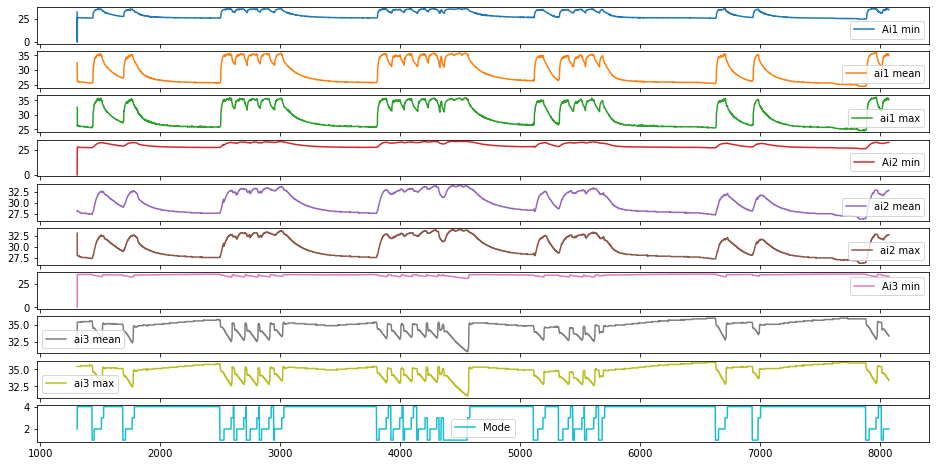

In [68]:
data2.plot(figsize=(16, 8), subplots=True)

#### Проверим, насколько точно можно "прогнозировать" следующее значение ряда, если в качестве прогноза брать текущее значение.


In [9]:
shifted_data2 = (data2[['ai1 mean', 'ai2 mean', 'ai3 mean']] - data2[['ai1 mean', 'ai2 mean', 'ai3 mean']].shift(1)).iloc[1:]

In [10]:
shifted_data2.describe()

,ai1 mean,ai2 mean,ai3 mean
count,6760.000000,6760.000000,6760.000000
mean,0.001314,0.000710,-0.000296
std,0.149060,0.040442,0.081988
min,-0.760000,-0.420000,-0.490000
25%,-0.030000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.010000,0.000000,0.000000
max,3.240000,0.170000,2.180000


array([[<AxesSubplot:title={'center':'ai1 mean'}>,
        <AxesSubplot:title={'center':'ai2 mean'}>],
       [<AxesSubplot:title={'center':'ai3 mean'}>, <AxesSubplot:>]],
      dtype=object)

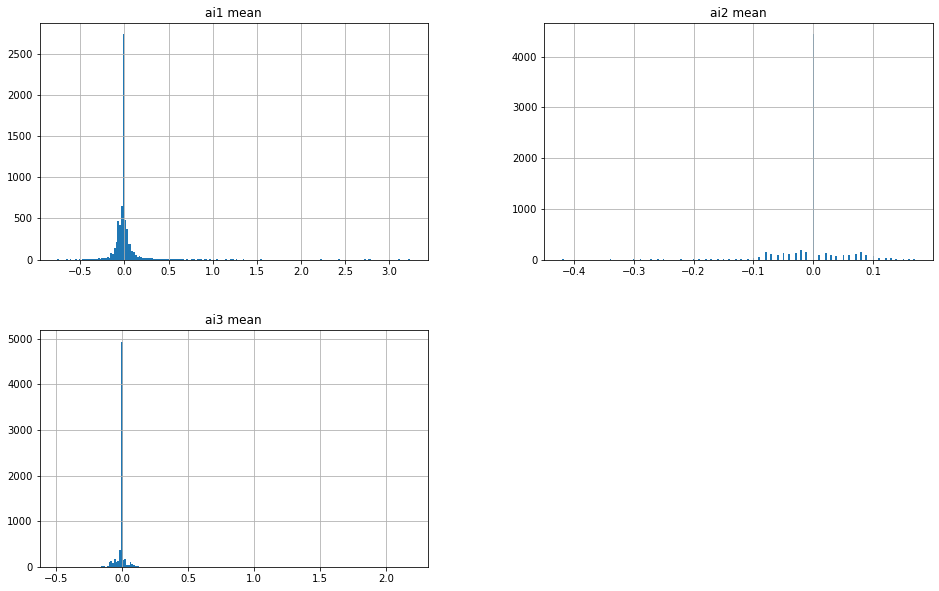

In [11]:
shifted_data2.hist(bins=200, figsize=(16, 10))

Наблюдаются очень редкие скачки температуры датчиков 1 и 3. По значениям квартилей видно, что почти все изменения температуры находятся в районе нуля. 

Датчики 1 и 3 измеряют температуру жидкости. Судя по принципу работы установки, скачки температуры более 0.2°С за минуту наблюдаются только в моменты, когда, при наполнении бака, жидкость касается датчика.

Это является серьёзной проблемой для нас, так как мы собираемся делать выводы о режимах работы оборудования по абсолютному значению ошибки прогноза, а эта ошибка будет достигать значений порядка 1°С только в редкие моменты, когда уровень жидкости в баке достигает датчика.

##### Теперь возьмём самую простую метрику, R^2, и посчитаем её для этой "элементарной модели".

In [12]:
print(f'Temp1 R^2={r2_score(data2.iloc[:-1, 0], data2.iloc[1:, 0]):.5f}')
print(f'Temp2 R^2={r2_score(data2.iloc[:-1, 1], data2.iloc[1:, 1]):.5f}')
print(f'Temp3 R^2={r2_score(data2.iloc[:-1, 2], data2.iloc[1:, 2]):.5f}')

Temp1 R^2=0.99762
Temp2 R^2=0.99843
Temp3 R^2=0.99789


* Как видим, следующее значение очень точно предсказывается предыдущим, предсказвать моделью непосредственно температуру не имеет смысла. 
* Будем строить модель, предсказывающую изменение температуры.
* Здесь необходимо сразу указать на следующую проблему: почти все предсказываемые значения для датчиков 1 и 3 находятся вблизи нуля, есть всего несколько очень больших выбросов. Модель (особенно, если использовать L2 loss) будет обучаться, преимущественно, по этим нескольким выбросам, а более 99.9% значений предсказывать будет относительно плохо. Распределение ошибки здесь не похоже ни на распределение Гаусса, ни на Лапласса, поэтому, строго говоря, даже использование L1 loss здесь некорректно.
* В качестве бейзлайна используем модель, обучаемую с L1 loss, но в будущем, для улучшения качества может понадобиться корректировка функции потерь, либо преобразование таргета (например, можно применить преобразование при помощи логистической функции).

##### Коэффициенты эксцесса для изменений показаний 3х датчиков:

In [13]:
print(f'Temp1 Kurtosis={kurtosis(shifted_data2.iloc[:, 0])}')
print(f'Temp2 Kurtosis={kurtosis(shifted_data2.iloc[:, 1])}')
print(f'Temp3 Kurtosis={kurtosis(shifted_data2.iloc[:, 2])}')

Temp1 Kurtosis=189.59454374238564
Temp2 Kurtosis=7.954764396269425
Temp3 Kurtosis=206.89743628536993


##### Более релевантной метрикой качетва, чем коэффициент детерминации будет MAE:

In [14]:
print(f'Temp1 MAE={mean_absolute_error(data2.iloc[:-1, 0], data2.iloc[1:, 0]):.5f}°C')
print(f'Temp2 MAE={mean_absolute_error(data2.iloc[:-1, 1], data2.iloc[1:, 1]):.5f}°C')
print(f'Temp3 MAE={mean_absolute_error(data2.iloc[:-1, 2], data2.iloc[1:, 2]):.5f}°C')

Temp1 MAE=0.07558°C
Temp2 MAE=0.05403°C
Temp3 MAE=0.07089°C


Полученные значения будем использовать в качестве опорных для оценки качества моделей.

### Генерация синтетических фичей

#### Для понимания того, какие процессы происходят в установке, и как они влияют на показания датчиков, составил следующее описание:

* **Mode=4:** Начальное состояние системы. 
Бак №1 пуст, бак №2 наполнен, газ (датчики 1 и 2) в первом баке постепенно охлаждается до температуры примерно 24°С (вероятно, температура воздуха в цехе), скорость охлаждения пропорциональна разности температур. Температура в баке №2 поддерживается на уровне 34..36°C системой управления.
* **Mode=1:**
В этом режиме жидкость перекачивается в бак №1. Пока уровень жидкости не достиг датчиков, температура в баке №1 продолжает приближаться к Тцеха, затем (жидкость доходит до датчика) начинает расти до Тпроцесса, на уровне около 35°. В баке №2 температура начинает быстро падать после того, как уровень жидкости опустится ниже датчика.
* **Mode=2:** Рабочий режим.
Основной технологический процесс. В баке №1 поддерживается постоянная температура жидкости. В баке №2 температура газа быстро снижается.
* **Mode=3:**
Перекачивание жидкости из бака №1 в бак №2. Температура в баке №1 снижается постепенно. В баке №2 температура испытывает резкий скачок вверх, когда жидкость достигает датчика.

#### Подумаем, что может пойти не так:

* **Mode=4:** Выход температуры в баке №2 за установленные в системе управления температурой пределы (неисправность системы поддержания температуры), слишком медленный нагрев (неисправность нагревателя) жидкости в баке №2 или слишком быстрое её охлаждение (нарушение теплоизоляции). Несоответствие скорости охлаждения (нарушение теплоизоляции или неполное удаление продукта реакции) бака №1 текущей разности температур (температур в баке и в цехе). 
* **Mode=1:** Переход от охлаждения к нагреву в баке №1 происходит позже обычного (недостаточная производительность насоса), необычная скорость нагрева или охлаждения в баке №1. Скачок температуры в баке №2 происходит позже обычного (недостаточная производительность насоса).
* **Mode=2:** Выход температуры в баке №1 за установленные в системе управления температурой пределы (неисправность системы поддержания температуры), слишком медленный нагрев (неисправность нагревателя) жидкости в баке №1 или слишком быстрое её охлаждение (нарушение теплоизоляции). Нетипичная скорость охлаждения в баке №2.
* **Mode=3:** Нетипичная скорость охлаждения в баке №1. Переход от охлаждения к нагреву в баке №2 происходит позже обычного (недостаточная производительность насоса).

#### В качестве синтетических фичей нам понадобятся:
* Лаговые фичи: значения температуры с лагами 1, 2 и 3 шага (9 фичей)
* One-hot encoding колонки "Mode" (4 колонки)
* Время, которое прошло от начала каждого цикла (4 колонки)
* Время, которое прошло от начала текущего цикла (1 колонка)
* Сглаженные при помощи EMA скорости изменения температур на каждом из 3х датчиков (3 колонки, если использовать один период усреднения, 6..12, если использовать несколько периодов)
* Нормированная на разность температур в цехе и в баке №1 скорость охлаждения по датчикам 1 и 2 (2 колонки)


Наиболее простой моделью, которая может учесть указанные особенности, кажется GBMT. Её и будем использовать для бейзлайна, для того чтобы оценивать эффективность более сложной LSTM (в качестве реализации GBMT возьмём CatBoost просто потому что я им пользуюсь чаще, в случае, если понадобится высокопроизводительная модель, можно будет заменить на LightGBM).

In [15]:
# Generate volatility features
def get_volatility(data: pd.DataFrame) -> pd.DataFrame:
    
    result = pd.DataFrame()

    result['Ai1_volat+'] = data['ai1 max'] - data['ai1 mean']
    result['Ai2_volat+'] = data['ai2 max'] - data['ai2 mean']
    result['Ai3_volat+'] = data['ai3 max'] - data['ai3 mean']
    result['Ai1_volat-'] = data['ai1 mean'] - data['Ai1 min']
    result['Ai2_volat-'] = data['ai2 mean'] - data['Ai2 min']
    result['Ai3_volat-'] = data['ai3 mean'] - data['Ai3 min']
    
    return result

# Generate lag features
def get_lags(data: pd.DataFrame) -> pd.DataFrame:
    
    result = pd.DataFrame()

    result['Temp1_shift1'] = data['ai1 mean'].shift(1, fill_value=data2['ai1 mean'].iloc[0])
    result['Temp1_shift2'] = data['ai1 mean'].shift(2, fill_value=data2['ai1 mean'].iloc[0])
    result['Temp1_shift3'] = data['ai1 mean'].shift(3, fill_value=data2['ai1 mean'].iloc[0])
    result['Temp1_shift4'] = data['ai1 mean'].shift(4, fill_value=data2['ai1 mean'].iloc[0])
    result['Temp1_shift5'] = data['ai1 mean'].shift(5, fill_value=data2['ai1 mean'].iloc[0])

    result['Temp2_shift1'] = data['ai2 mean'].shift(1, fill_value=data2['ai2 mean'].iloc[0])
    result['Temp2_shift2'] = data['ai2 mean'].shift(2, fill_value=data2['ai2 mean'].iloc[0])

    result['Temp3_shift1'] = data['ai3 mean'].shift(1, fill_value=data2['ai3 mean'].iloc[0])
    result['Temp3_shift2'] = data['ai3 mean'].shift(2, fill_value=data2['ai3 mean'].iloc[0])
    
    return result

# Generate mode one hot encoding features
def get_mode_ohe(data: pd.DataFrame) -> pd.DataFrame:
    
    result = pd.DataFrame()
    
    result['Mode1'] = (data2.Mode == 1)*1
    result['Mode2'] = (data2.Mode == 2)*1
    result['Mode3'] = (data2.Mode == 3)*1
    result['Mode4'] = (data2.Mode == 4)*1
    
    return result

# Generate uptime features
def get_uptime(data: pd.DataFrame) -> pd.DataFrame:

    result = pd.DataFrame()
    
    result['Mode1_uptime'] = np.nan
    result['Mode2_uptime'] = np.nan
    result['Mode3_uptime'] = np.nan
    result['Mode4_uptime'] = np.nan
    result['Cycle_uptime'] = np.nan

    mode1_time = 0
    mode2_time = 0
    mode3_time = 0
    mode4_time = 0
    cycle_time = 0
    current_mode1 = 0
    current_mode2 = 0
    current_mode3 = 0
    current_mode4 = 0

    for index, row in data.iterrows():
        mode1_time += 1
        mode2_time += 1
        mode3_time += 1
        mode4_time += 1
        cycle_time += 1

        if current_mode1 == 0 and row['Mode1'] == 1:
            mode1_time = 1
            cycle_time = 1
        if current_mode2 == 0 and row['Mode2'] == 1:
            mode2_time = 1
            cycle_time = 1
        if current_mode3 == 0 and row['Mode3'] == 1:
            mode3_time = 1
            cycle_time = 1
        if current_mode4 == 0 and row['Mode4'] == 1:
            mode4_time = 1
            cycle_time = 1

        current_mode1 = row['Mode1']
        current_mode2 = row['Mode2']
        current_mode3 = row['Mode3']
        current_mode4 = row['Mode4']

        result.loc[index, 'Mode1_uptime'] = mode1_time
        result.loc[index, 'Mode2_uptime'] = mode2_time
        result.loc[index, 'Mode3_uptime'] = mode3_time
        result.loc[index, 'Mode4_uptime'] = mode4_time
        result.loc[index, 'Cycle_uptime'] = cycle_time
        
    return result

def generate_ema(data: pd.Series, periods: np.array, columns: list) -> pd.DataFrame:
    alphas = 2 / (periods + 1)

    # Memory allocation for resulting values
    result_ema = np.ndarray((data.shape[0], len(alphas)), dtype=float)

    # Fill buffer vectors
    ema_buffer = np.ones((len(alphas),), dtype=float) * data.iloc[0]
    result_ema[0] = ema_buffer


    # Calculation of EMA, DMA, TMA, QMA
    for i in range(1, data.shape[0]):
        ema_buffer = ema_buffer * (1 - alphas) + alphas * data.iloc[i]
        result_ema[i] = ema_buffer


    # Convert result into pandas DaraFrame
    return pd.DataFrame(result_ema, index=data.index, columns=columns)

# Generate differential features
def get_diffs(data: pd.DataFrame) -> pd.DataFrame:

    diff_data = pd.DataFrame()

    diff_data['Temp1_diff1'] = data['ai1 mean'] - data['ai1 mean'].shift(1, fill_value=data2['ai1 mean'].iloc[0])
    diff_data['Temp1_diff2'] = data['ai1 mean'] - data['ai1 mean'].shift(2, fill_value=data2['ai1 mean'].iloc[0])
    diff_data['Temp1_diff3'] = data['ai1 mean'] - data['ai1 mean'].shift(3, fill_value=data2['ai1 mean'].iloc[0])
    diff_data['Temp1_diff4'] = data['ai1 mean'] - data['ai1 mean'].shift(4, fill_value=data2['ai1 mean'].iloc[0])
    diff_data['Temp2_diff1'] = data['ai2 mean'] - data['ai2 mean'].shift(1, fill_value=data2['ai2 mean'].iloc[0])
    diff_data['Temp3_diff1'] = data['ai3 mean'] - data['ai3 mean'].shift(1, fill_value=data2['ai3 mean'].iloc[0])

    return diff_data

# Generate cooling down features
def get_cool_down(data: pd.DataFrame) -> pd.DataFrame:
    
    result = pd.DataFrame()

    result['Temp1_cooling_down'] = (data['Temp1_diff3'] / (data['Temp1_ema_long'] - 23))
    result['Temp2_cooling_down'] = (data['Temp2_diff1'] / (data['Temp2_ema_long'] - 23))
    
    return result

In [16]:
# Add volatility features
data1 = data1.join(get_volatility(data1))
data2 = data2.join(get_volatility(data2))

# Лаговые фичи: значения температуры с лагами 1 и 2 шага (6 колонок)
data1 = data1.join(get_lags(data1))
data2 = data2.join(get_lags(data2))

# One-hot encoding колонки "Mode" (4 колонки)
data1 = data1.join(get_mode_ohe(data1))
data2 = data2.join(get_mode_ohe(data2))

# Время, которое прошло от начала каждого цикла (4 колонки). Время, которое прошло от начала текущего цикла (1 колонка).
data1 = data1.join(get_uptime(data1))
data2 = data2.join(get_uptime(data2))


# Фичи, полученные дифференцированием
data1 = data1.join(get_diffs(data1))
data2 = data2.join(get_diffs(data2))

# Сглаженные при помощи EMA скорости изменения температур на каждом из 3х датчиков (9 колонок, периоды (окна) 1.5, 4 и 25) плюс 3 несглаженных значения
data1 = data1.join(generate_ema(data1['Temp1_diff1'], np.array([2, 5, 25]), ['Temp1_ema_short', 'Temp1_ema_avg', 'Temp1_ema_long']))
data1 = data1.join(generate_ema(data1['Temp2_diff1'], np.array([2, 5, 25]), ['Temp2_ema_short', 'Temp2_ema_avg', 'Temp2_ema_long']))
data1 = data1.join(generate_ema(data1['Temp3_diff1'], np.array([2, 5, 25]), ['Temp3_ema_short', 'Temp3_ema_avg', 'Temp3_ema_long']))
data2 = data2.join(generate_ema(data2['Temp1_diff1'], np.array([2, 5, 25]), ['Temp1_ema_short', 'Temp1_ema_avg', 'Temp1_ema_long']))
data2 = data2.join(generate_ema(data2['Temp2_diff1'], np.array([2, 5, 25]), ['Temp2_ema_short', 'Temp2_ema_avg', 'Temp2_ema_long']))
data2 = data2.join(generate_ema(data2['Temp3_diff1'], np.array([2, 5, 25]), ['Temp3_ema_short', 'Temp3_ema_avg', 'Temp3_ema_long']))

# Нормированная на разность температур в цехе и в баке №1 скорость остывания по датчикам 1 и 2 (2 колонки)
data1 = data1.join(get_cool_down(data1))
data2 = data2.join(get_cool_down(data2))

# Drop unnecessary columns
data1.drop(columns=['Ai1 min', 'ai1 max', 'Ai2 min', 'ai2 max', 'Ai3 min', 'ai3 max', 'Mode'], axis=1, inplace=True)
data2.drop(columns=['Ai1 min', 'ai1 max', 'Ai2 min', 'ai2 max', 'Ai3 min', 'ai3 max', 'Mode'], axis=1, inplace=True)

#### Формируем таргеты



In [17]:
# В качестве таргета - следующее значение температуры минус текущее значение
target_temp1 = data2['ai1 mean'].shift(-1, fill_value=data2['ai1 mean'].iloc[-1]) - data2['ai1 mean']
target_temp2 = data2['ai2 mean'].shift(-1, fill_value=data2['ai2 mean'].iloc[-1]) - data2['ai2 mean']
target_temp3 = data2['ai3 mean'].shift(-1, fill_value=data2['ai3 mean'].iloc[-1]) - data2['ai3 mean']

#### Модели CatBoost

In [41]:
cb_model = CatBoostRegressor(n_estimators=3000,
                             learning_rate=0.02,
                             rsm=0.8,
                             depth=6,
                             loss_function='MAE',
                             thread_count=-1,
                             random_seed=0,
                             logging_level='Silent')

cb_temp1_model = cb_model.copy()
cb_temp2_model = cb_model.copy()
cb_temp3_model = cb_model.copy()

params = {
    'loss_function': 'MAE',
    'iterations': 1500,
    'depth': 7,
    'rsm': 0.8,
    'random_seed': 0,
    'learning_rate': 0.02
}

In [42]:
print(f'Temp1 MAE={mean_absolute_error(data2.iloc[:-1, 0], data2.iloc[1:, 0]):.3f}°C')
cv_data = cv(
    params=params,
    pool=Pool(data2, label=target_temp1),
    fold_count=6, 
    shuffle=False, 
    partition_random_seed=0,
    plot=True, 
    stratified=False, 
    verbose=False
)

n_estimators=np.argmin(cv_data['test-MAE-mean'])
print(f'Best n_estimators={n_estimators}')
cb_temp1_model.set_params(n_estimators=n_estimators)
cb_temp1_model.fit(data2, target_temp1)

feature_importance = cb_temp1_model.get_feature_importance(Pool(data2, target_temp1))
for item in zip(data2.columns.tolist(), feature_importance):
    print(item)

Temp1 MAE=0.054°C


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [ ]:
print(f'Temp2 MAE={mean_absolute_error(data2.iloc[:-1, 1], data2.iloc[1:, 1]):.3f}°C')
cv_data = cv(
    params=params,
    pool=Pool(data2, label=target_temp2),
    fold_count=6, 
    shuffle=False, 
    partition_random_seed=0,
    plot=True, 
    stratified=False, 
    verbose=False
)

n_estimators=np.argmin(cv_data['test-MAE-mean'])
print(f'Best n_estimators={n_estimators}')
cb_temp2_model.set_params(n_estimators=n_estimators)
cb_temp2_model.fit(data2, target_temp2)

feature_importance = cb_temp2_model.get_feature_importance(Pool(data2, target_temp2))
for item in zip(data2.columns.tolist(), feature_importance):
    print(item)

In [ ]:
print(f'Temp3 MAE={mean_absolute_error(data2.iloc[:-1, 2], data2.iloc[1:, 2]):.3f}°C')
cv_data = cv(
    params=params,
    pool=Pool(data2, label=target_temp3),
    fold_count=6, 
    shuffle=False, 
    partition_random_seed=0,
    plot=True, 
    stratified=False, 
    verbose=False
)

n_estimators=np.argmin(cv_data['test-MAE-mean'])
print(f'Best n_estimators={n_estimators}')
cb_temp3_model.set_params(n_estimators=n_estimators)
cb_temp3_model.fit(data2, target_temp3)

feature_importance = cb_temp3_model.get_feature_importance(Pool(data2, target_temp3))
for item in zip(data2.columns.tolist(), feature_importance):
    print(item)

In [ ]:
print('Temp1 error describe \n', (cb_temp1_model.predict(data2) - target_temp1).describe(), '\n')
print('Temp2 error describe \n', (cb_temp2_model.predict(data2) - target_temp2).describe(), '\n')
print('Temp3 error describe \n', (cb_temp3_model.predict(data2) - target_temp3).describe(), '\n')

### LSTM

In [ ]:
# Добавляем лаговые фичи: значения температуры с лагами 3, 4 и 5 шагов (9 колонок)
'''data2['Temp1_shift3'] = data2['ai1 mean'].shift(3, fill_value=data2['ai1 mean'].iloc[0])
data2['Temp1_shift4'] = data2['ai1 mean'].shift(4, fill_value=data2['ai1 mean'].iloc[0])
data2['Temp1_shift5'] = data2['ai1 mean'].shift(5, fill_value=data2['ai1 mean'].iloc[0])

data2['Temp2_shift3'] = data2['ai2 mean'].shift(3, fill_value=data2['ai2 mean'].iloc[0])
data2['Temp2_shift4'] = data2['ai2 mean'].shift(4, fill_value=data2['ai2 mean'].iloc[0])
data2['Temp2_shift5'] = data2['ai2 mean'].shift(5, fill_value=data2['ai2 mean'].iloc[0])

data2['Temp3_shift3'] = data2['ai3 mean'].shift(3, fill_value=data2['ai3 mean'].iloc[0])
data2['Temp3_shift4'] = data2['ai3 mean'].shift(4, fill_value=data2['ai3 mean'].iloc[0])
data2['Temp3_shift5'] = data2['ai3 mean'].shift(5, fill_value=data2['ai3 mean'].iloc[0])'''

In [ ]:
data2

In [ ]:
# Z-scaling of data
scaler = StandardScaler()
scaler.fit(data2)
scaled_data = scaler.transform(data2)
scaled_data = np.reshape(scaled_data, (scaled_data.shape[0], scaled_data.shape[1], 1))

In [ ]:
scaled_data.shape

In [ ]:
# Формируем массив labels (таргет)
labels = np.vstack((target_temp1, target_temp2, target_temp3)).T
labels.shape

In [ ]:
# Построение LSTM модели
def get_model(lstm_units, dense1_units, dense2_units, dense3_units):
    model = Sequential()

    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(scaled_data.shape[1], 1)))
    model.add(Dropout(0.5))

    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(Dropout(0.5))
    
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(0.5))

    model.add(Dense(units=dense1_units, activation='tanh'))
    model.add(Dropout(0.5))

    model.add(Dense(units=dense1_units, activation='tanh'))
    model.add(Dropout(0.5))
    
    model.add(Dense(units=dense1_units, activation='tanh'))
    model.add(Dropout(0.5))

    model.add(Dense(units=dense2_units, activation='tanh'))
    model.add(Dropout(0.5))

    model.add(Dense(units=dense3_units, activation='tanh'))
    model.add(Dropout(0.5))

    model.add(Dense(units=labels.shape[1]))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.MeanAbsoluteError())
    
    return model

In [ ]:
lstm_model = get_model(lstm_units=128, 
                       dense1_units=256, 
                       dense2_units=256, 
                       dense3_units=128)

In [ ]:
lstm_model.fit(scaled_data[:5000], labels[:5000], epochs = 30, batch_size = 16)

In [ ]:
predictions = lstm_model.predict(scaled_data[:5000])
print(f'Temp1 train MAE={mean_absolute_error(predictions[:, 0], labels[:5000, 0]):.4f}°C')
print(f'Temp2 train MAE={mean_absolute_error(predictions[:, 1], labels[:5000, 1]):.4f}°C')
print(f'Temp3 train MAE={mean_absolute_error(predictions[:, 2], labels[:5000, 2]):.4f}°C')

In [ ]:
predictions = lstm_model.predict(scaled_data[5000:])
print(f'Temp1 test MAE={mean_absolute_error(predictions[:, 0], labels[5000:, 0]):.4f}°C')
print(f'Temp2 test MAE={mean_absolute_error(predictions[:, 1], labels[5000:, 1]):.4f}°C')
print(f'Temp3 test MAE={mean_absolute_error(predictions[:, 2], labels[5000:, 2]):.4f}°C')

In [ ]:
for const in range(1, 17):
    lstm_model = get_model(lstm_units=const*2, 
                       dense1_units=const*4, 
                       dense2_units=const*4, 
                       dense3_units=const*4)
    
    lstm_model.fit(scaled_data[:5000], labels[:5000], epochs = 50, batch_size = 8, verbose=0)
    
    predictions = lstm_model.predict(scaled_data[:5000])
    print(f'Const={const}')
    print(f'Temp1 train MAE={mean_absolute_error(predictions[:, 0], labels[:5000, 0]):.3f}°C')
    print(f'Temp2 train MAE={mean_absolute_error(predictions[:, 1], labels[:5000, 1]):.3f}°C')
    print(f'Temp3 train MAE={mean_absolute_error(predictions[:, 2], labels[:5000, 2]):.3f}°C')
    predictions = lstm_model.predict(scaled_data[5000:])
    print(f'Temp1 test MAE={mean_absolute_error(predictions[:, 0], labels[5000:, 0]):.3f}°C')
    print(f'Temp2 test MAE={mean_absolute_error(predictions[:, 1], labels[5000:, 1]):.3f}°C')
    print(f'Temp3 test MAE={mean_absolute_error(predictions[:, 2], labels[5000:, 2]):.3f}°C')

### CatBoost

Лучшие результаты, которые удалось получить, хуже, чем результаты модели CatBoost

Для работы с фиксированным порогом ±1°С, обучим модели CatBoost с L2 функцией ошибки. Так как определение ошибки будет производиться по фиксированному порогу, модель необходимо обучить на предсказание больших выбросов.


In [35]:
params = {
    'loss_function': 'RMSE',
    'iterations': 2000,
    'depth': 6,
    'rsm': 0.2,
    'random_seed': 0,
    'learning_rate': 0.018
}

cb_model = CatBoostRegressor(n_estimators=1000,
                             learning_rate=params['learning_rate'],
                             rsm=params['rsm'],
                             depth=params['depth'],
                             loss_function=params['loss_function'],
                             thread_count=-1,
                             random_seed=0,
                             logging_level='Silent')

cb_temp1_model = cb_model.copy()
cb_temp2_model = cb_model.copy()
cb_temp3_model = cb_model.copy()



In [36]:
print(f'Temp1 RMSE={mean_squared_error(data2.iloc[:-1, 0], data2.iloc[1:, 0])**0.5:.4f}°C')
cv_data = cv(
    params=params,
    pool=Pool(data2, label=target_temp1),
    fold_count=6, 
    shuffle=False, 
    partition_random_seed=0,
    plot=True, 
    stratified=False, 
    verbose=False
)

n_estimators=np.argmin(cv_data['test-RMSE-mean'])
print(f'Best n_estimators={n_estimators}')
cb_temp1_model.set_params(n_estimators=n_estimators)
cb_temp1_model.fit(data2, target_temp1)

feature_importance = cb_temp1_model.get_feature_importance(Pool(data2, target_temp1))
for item in zip(data2.columns.tolist(), feature_importance):
    print(item)

Temp1 RMSE=0.1491°C


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best n_estimators=594
('ai1 mean', 7.276034999749932)
('ai2 mean', 0.06174760204919451)
('ai3 mean', 0.2582297959317045)
('Ai1_volat+', 18.776605947076657)
('Ai2_volat+', 0.1859464526954539)
('Ai3_volat+', 0.004756716316829005)
('Ai1_volat-', 1.1310306967498078)
('Ai2_volat-', 0.4894072168833773)
('Ai3_volat-', 0.020169746478646226)
('Temp1_shift1', 2.6960286307778616)
('Temp1_shift2', 0.983054928447729)
('Temp1_shift3', 0.5361876369523244)
('Temp1_shift4', 0.622805444746508)
('Temp1_shift5', 0.8644445497798305)
('Temp2_shift1', 0.7516790646549758)
('Temp2_shift2', 0.07253328848746385)
('Temp3_shift1', 0.30088317924125113)
('Temp3_shift2', 0.14127444095163263)
('Mode1', 0.6656702765216979)
('Mode2', 0.15957156793291674)
('Mode3', 2.1639808258400173)
('Mode4', 0.11267487194838544)
('Mode1_uptime', 12.472919713461245)
('Mode2_uptime', 0.08919413564604443)
('Mode3_uptime', 3.416771244508518)
('Mode4_uptime', 0.03890524134289355)
('Cycle_uptime', 5.519777770766956)
('Temp1_diff1', 2.069264

In [50]:
print(f'Temp2 RMSE={mean_squared_error(data2.iloc[:-1, 1], data2.iloc[1:, 1])**0.5:.4f}°C')
cv_data = cv(
    params=params,
    pool=Pool(data2, label=target_temp2),
    fold_count=3, 
    shuffle=False, 
    partition_random_seed=0,
    plot=True, 
    stratified=False, 
    verbose=False
)

n_estimators=np.argmin(cv_data['test-RMSE-mean'])
print(f'Best n_estimators={n_estimators}')
cb_temp2_model.set_params(n_estimators=n_estimators)
cb_temp2_model.fit(data2, target_temp2)

feature_importance = cb_temp2_model.get_feature_importance(Pool(data2, target_temp2))
for item in zip(data2.columns.tolist(), feature_importance):
    print(item)

Temp2 RMSE=0.0404°C


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best n_estimators=827
('ai1 mean', 1.0743518312207638)
('ai2 mean', 1.7981903063460651)
('ai3 mean', 0.8265270411656297)
('Ai1_volat+', 0.10193036310918836)
('Ai2_volat+', 8.90779494647669)
('Ai3_volat+', 0.19560186900695362)
('Ai1_volat-', 0.24054816832334436)
('Ai2_volat-', 19.262460792172657)
('Ai3_volat-', 0.18777734618434336)
('Temp1_shift1', 0.9158949691207792)
('Temp1_shift2', 0.47307063084022155)
('Temp1_shift3', 0.6609002184973478)
('Temp1_shift4', 0.934387050444759)
('Temp1_shift5', 0.8399882576328024)
('Temp2_shift1', 2.754119387747746)
('Temp2_shift2', 2.182818141852855)
('Temp3_shift1', 1.2531710641168148)
('Temp3_shift2', 0.8438137885823416)
('Mode1', 0.5451028345966304)
('Mode2', 0.22922108227260357)
('Mode3', 0.1715574494787161)
('Mode4', 0.3888672468677747)
('Mode1_uptime', 2.823312026208193)
('Mode2_uptime', 1.0548600537712778)
('Mode3_uptime', 0.6049023307959444)
('Mode4_uptime', 1.4943342671766755)
('Cycle_uptime', 2.2473695121021158)
('Temp1_diff1', 0.4089616596876

In [51]:
print(f'Temp3 RMSE={mean_squared_error(data2.iloc[:-1, 2], data2.iloc[1:, 2])**0.5:.4f}°C')
cv_data = cv(
    params=params,
    pool=Pool(data2, label=target_temp3),
    fold_count=3, 
    shuffle=False, 
    partition_random_seed=0,
    plot=True, 
    stratified=False, 
    verbose=False
)

n_estimators=np.argmin(cv_data['test-RMSE-mean'])
print(f'Best n_estimators={n_estimators}')
cb_temp3_model.set_params(n_estimators=n_estimators)
cb_temp3_model.fit(data2, target_temp3)

feature_importance = cb_temp3_model.get_feature_importance(Pool(data2, target_temp3))
for item in zip(data2.columns.tolist(), feature_importance):
    print(item)

Temp3 RMSE=0.0820°C


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Best n_estimators=1956
('ai1 mean', 0.8095167463042059)
('ai2 mean', 0.30190558745618384)
('ai3 mean', 7.445681879398518)
('Ai1_volat+', 0.25064204897658277)
('Ai2_volat+', 0.1159951704934949)
('Ai3_volat+', 9.705159806225549)
('Ai1_volat-', 0.32000780120854266)
('Ai2_volat-', 0.05134319847875914)
('Ai3_volat-', 8.174160568262653)
('Temp1_shift1', 1.8863701227820084)
('Temp1_shift2', 1.3651944092071924)
('Temp1_shift3', 1.0664706521764358)
('Temp1_shift4', 0.9536774372558506)
('Temp1_shift5', 1.3181154275378102)
('Temp2_shift1', 0.27067357054963065)
('Temp2_shift2', 0.27740526600879406)
('Temp3_shift1', 4.831415555712925)
('Temp3_shift2', 1.1213355207506204)
('Mode1', 0.2951505919859069)
('Mode2', 0.12973657387596146)
('Mode3', 3.864443281023102)
('Mode4', 0.1629326235043037)
('Mode1_uptime', 3.783501446650737)
('Mode2_uptime', 0.386661800459233)
('Mode3_uptime', 8.711971579309047)
('Mode4_uptime', 0.32920910732296416)
('Cycle_uptime', 10.525740357181412)
('Temp1_diff1', 0.205427812898

In [20]:
print('Temp1 error describe \n', (cb_temp1_model.predict(data2) - target_temp1).describe(), '\n')
#print('Temp2 error describe \n', (cb_temp2_model.predict(data2) - target_temp2).describe(), '\n')
#print('Temp3 error describe \n', (cb_temp3_model.predict(data2) - target_temp3).describe(), '\n')

Temp1 error describe 
 count    6761.000000
mean       -0.000010
std         0.055089
min        -0.553979
25%        -0.015557
50%        -0.001518
75%         0.014960
max         0.496279
Name: ai1 mean, dtype: float64 

